In [822]:
#Necesary libraries
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import cvlib
import joblib

def extent(cnt):
    """ Receives the dims of a contour and returns its values
        
    Args:
        cnt (np array): The contour

    Returns:
        res (np array): The dimentions
    """

    area = cv.contourArea(cnt)
    x,y,w,h = cv.boundingRect(cnt)
    rect_area = w*h
    res = float(area)/rect_area
    return res

plt.style.use(['dark_background'])
%matplotlib inline

### Preparation of the plate

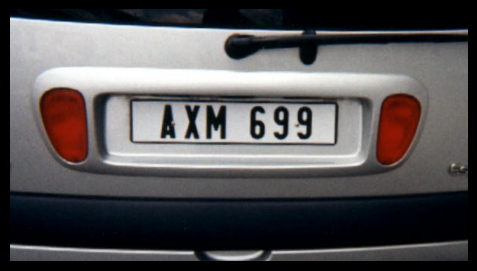

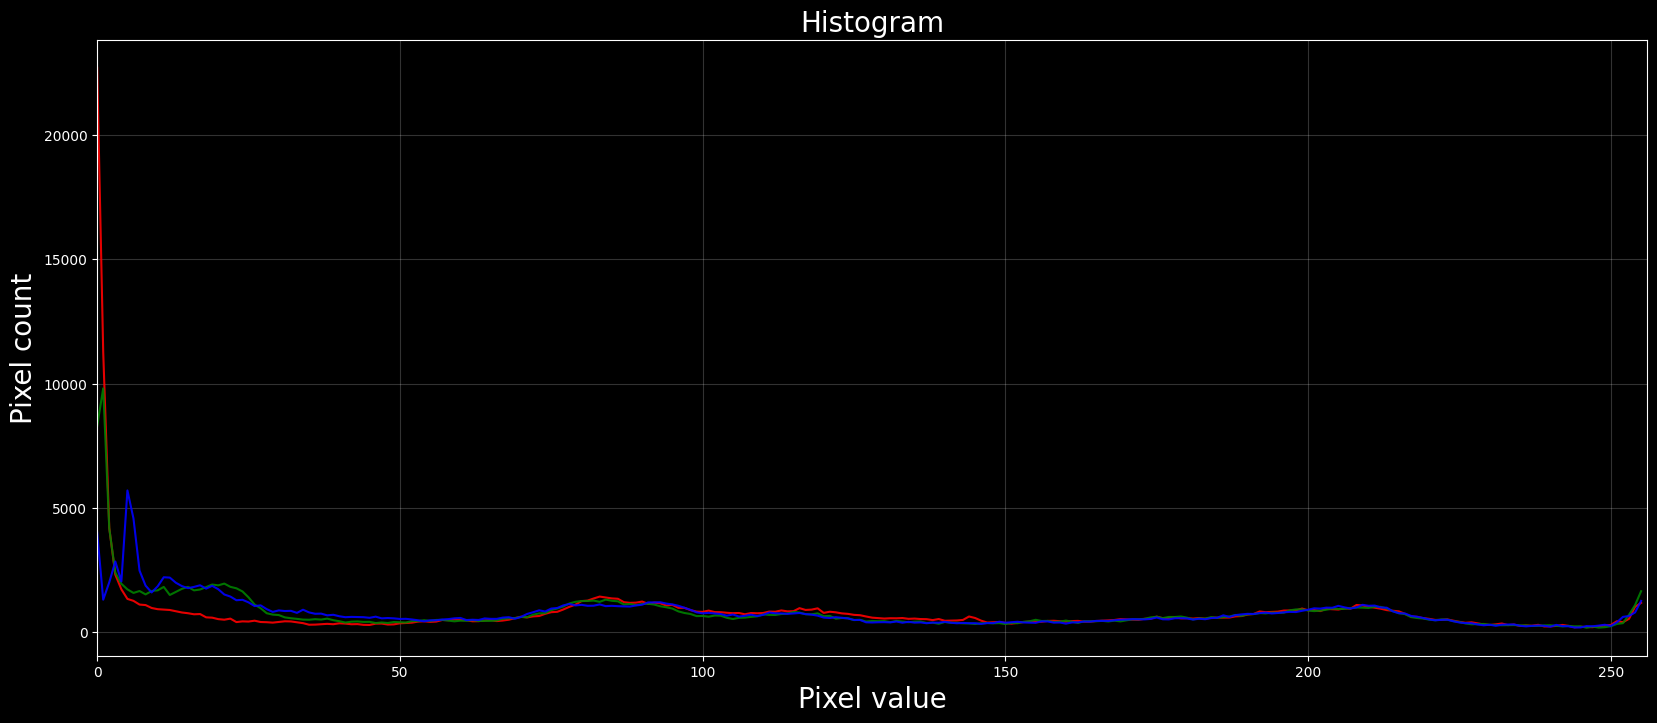

In [841]:
img_raw = cv.imread('LicencePlates/images197.jpg', cv.IMREAD_COLOR)
img_raw = cv.cvtColor(img_raw, cv.COLOR_BGR2RGB)
cvlib.imgview(img_raw)
cvlib.colorhist(img_raw)

In [842]:
# Variances expresed in the prev graf to get the lowest
red = np.var(img_raw[:,:,0])
green = np.var(img_raw[:,:,1])
blue = np.var(img_raw[:,:,2])

if blue < green and blue < red:
    imgray = img_raw[:,:,2]
elif green < blue and green < red:
    imgray = img_raw[:,:,1]
else:
    imgray = img_raw[:,:,0]

In [843]:
# Normalization of the image
_, imgray = cv.threshold(imgray, 210, 255,cv.THRESH_TRUNC)
_, imgray = cv.threshold(imgray, 60, 255,cv.THRESH_TOZERO)
imgray = cv.GaussianBlur(imgray, (5,5), 10)

In [844]:
# Getting the contours
thresh = cv.adaptiveThreshold(imgray, 255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV,17,1)
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
print("# Objects:", len(contours))

# Objects: 611


In [845]:
# Getting the plate searching the most rectangular one
img = img_raw.copy() 
m, n = 0, 0
for i, contorn in enumerate(contours):
    ext = extent(contorn)
    ext = round(ext, 2)
    x,y,w,h = cv.boundingRect(contorn)
    img = cv.drawContours(img,[contorn],0,(0,255,0),2)
    img = cv.rectangle(img,(x,y),(x+w,y+h),(0,255,255),2)
    if (ext > m):
        n = i 
        m = ext

In [846]:
# Plate identified
x, y, w, h = cv.boundingRect(contours[n])
objective = img_raw[y:y+h, x:x+w]
cv.rectangle(img_raw, (x, y), (x + w, y + h), (0, 255, 0), 4)
print(objective.shape)

(56, 268, 3)


### Extracting all the components in the plate

In [847]:
# Mapping the plate and getting shapes
h, w, _ = objective.shape
c_w = int(0.04 * w)
c_h = int(0.11 * h)
x1 = c_w
y1 = c_h
x2 = w - c_w
y2 = h - c_h
img = objective[y1:y2, x1:x2]

In [848]:
# Getting the original picture with the new coordinates
plate = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
plate = cv.GaussianBlur(plate, (7,7), 1)
hist = cv.calcHist([plate], [0], None, [256], [0, 256])

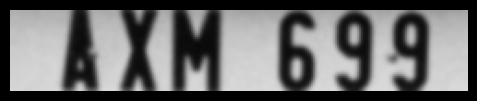

In [849]:
cvlib.imgview(plate)

In [850]:
# Binarizing
glow = sum(hist[100:])
threshold = 0.5
if glow / sum(hist) > threshold:
    img_bin = cv.adaptiveThreshold(plate, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 33, 5)
else:
    img_bin = cv.adaptiveThreshold(plate, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 23, -2)

In [851]:
# Cleaning the new image
kernel = np.ones((3, 3), np.uint8)
img_bin = cv.erode(img_bin, kernel, iterations=1)
components = cv.connectedComponentsWithStats(img_bin, connectivity=4)

In [852]:
# Getting the contours of all the elements
final = img.copy()
contours = []
w_med = []
h_med = []

for i in range(1, components[0]):
    x, y, w, h, area = components[2][i]
    contours.append(area)
    
mindex = np.argmax(contours)
mvalue = contours[mindex] * 0.10

In [853]:
# Identifying the letters in the plate
for i in range(1, components[0]):
    x, y, w, h, area = components[2][i]
    if area >= mvalue:
        if h > w:
            w_med.append(w)
            h_med.append(h)

if len(h_med) != 0:
    max_height = (sum(h_med)/len(h_med)) * 1.40
    min_height = (sum(h_med)/len(h_med)) * 0.75
else:
    max_height = plate.shape[0]
    min_height = 0

In [854]:
components[2]

array([[   0,    0,  248,   44, 8400],
       [  12,    0,    3,    3,    6],
       [  29,    0,   18,   44,  410],
       [  61,    0,   18,   44,  373],
       [  89,    0,   24,   44,  608],
       [ 126,    0,    1,    1,    1],
       [ 132,    0,    1,    1,    1],
       [ 146,    0,   19,   44,  376],
       [ 177,    0,   18,   44,  368],
       [ 235,    0,    1,    1,    1],
       [ 242,    0,    2,    1,    2],
       [ 208,    2,   18,   42,  363],
       [ 206,   26,    2,    2,    3]], dtype=int32)

X, 29, Y, 0, w, 18, h, 44,
X, 61, Y, 0, w, 18, h, 44,
X, 89, Y, 0, w, 24, h, 44,
X, 146, Y, 0, w, 19, h, 44,
X, 177, Y, 0, w, 18, h, 44,
X, 208, Y, 2, w, 18, h, 42,


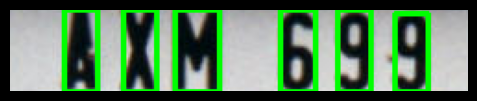

In [855]:
for i in range(1, components[0]):
    x, y, w, h, area = components[2][i]
    if area >= mvalue:
        if h > w:
            if h > min_height and h < max_height:
                cv.rectangle(final, (x, y), (x + w, y + h), (0, 255, 0), 2)
                print(f"X, {x}, Y, {y}, w, {w}, h, {h},")

cvlib.imgview(final)

### Getting the digits of the plate

In [856]:
glow = sum(hist[100:])
threshold = 0.5
if glow / sum(hist) > threshold:
    img_bin2 = cv.adaptiveThreshold(plate, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 33, 5)
else:
    img_bin2 = cv.adaptiveThreshold(plate, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 23, -2)

In [857]:
letters = []
for i in range(1, components[0]):
    x, y, w, h, area = components[2][i]
    if area >= mvalue:
        if h > w:
            if h > min_height and h < max_height:
                letra = img_bin2[y:y+h, x:x+w]
                letra = np.pad(letra, 5, 'constant', constant_values=255)
                new_size = cv.resize(letra, dsize=(75, 100), interpolation=cv.INTER_LANCZOS4)
                flatted = new_size.flatten()
                letters.append(flatted)

In [858]:
# Using the model to make the prediction
model = joblib.load("model.sav")

letra = model.predict(letters)
letra

array(['A', 'X', 'N', '6', '9', '9'], dtype='<U1')